# Predict an ONNX InferenceService

This example assumes you have already deployed the sample ONNX Inference Service. 

Deploy the sample ONNX InferenceSevice by following the instructions in the [README](https://github.com/kserve/kserve/blob/master/docs/samples/v1beta1/onnx/README.md)

In [26]:

%env MODEL_NAME=style
HOSTNAME=!(kubectl get inferenceservice "style-sample" -o jsonpath='{.status.url}' | cut -d "/" -f 3)
%env INGRESS_HOST=localhost
%env INGRESS_PORT=8080
%env SERVICE_HOSTNAME={HOSTNAME[0]}

env: MODEL_NAME=style
env: INGRESS_HOST=localhost
env: INGRESS_PORT=8080
env: SERVICE_HOSTNAME=style-sample.default.example.com


In [29]:
from PIL import Image
import numpy as np
import requests
import json
import os

# load & resize image
image = Image.open("image.jpg")
image = image.resize((224,224), Image.LANCZOS)
image

In [30]:
# preprocess image data
norm_img_data = np.array(image).astype("float32")
norm_img_data = np.transpose(norm_img_data, [2, 0, 1])
norm_img_data = np.expand_dims(norm_img_data, axis=0)
np.shape(norm_img_data)

(1, 3, 224, 224)

In [31]:
# Create request message to be sent to the predictor
message_data = {}
inputs = {}
message_data["inputs"] = []
inputs["name"] = "input1"
inputs["shape"] = norm_img_data.shape
inputs["datatype"] = "FP32"  # as the given onnx model expects float32
inputs["data"] = norm_img_data.tolist()
message_data["inputs"].append(inputs)

In [32]:
# Call predictor

service_hostname = os.environ["SERVICE_HOSTNAME"]
model_name = os.environ["MODEL_NAME"]
ingress_ip = "localhost"
ingress_port = os.environ["INGRESS_PORT"]
predictor_url = f"http://{ingress_ip}:{ingress_port}/v2/models/{model_name}/infer"
request_headers = {
    "Content-Type": "application/json",
    "Accept": "application/json",
    "Host": service_hostname,
}
response = requests.post(
    predictor_url, headers=request_headers, data=json.dumps(message_data)
)
print(response.status_code)

200


In [33]:
response_message = json.loads(response.text)
output1 = np.array(response_message["outputs"][0]["data"], dtype=np.float32)
output1 = output1.reshape(3, 224, 224)

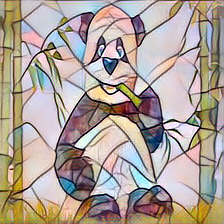

In [34]:
# postprocess
result = np.clip(output1, 0, 255)
result = result.transpose(1, 2, 0).astype("uint8")
img = Image.fromarray(result)
img